## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from engine.Engine import Engine
from assignment_algorithm.scoring_system.scoring_algorithm import ScoringAlgorithm
from assignment_algorithm.AssignEngine import AssignEngine
from utils.utils import convert_to_output_format_pandas, get_rep_assignment_summary, convert_to_test_output_format_pandas, compute_distance

## Load Test Files

In [2]:
# Load the CSV file into a pandas DataFrame
pd_test_pkg = pd.read_csv(r'C:\Users\YWANG1\OneDrive - The Cincinnati Insurance Company\Workspace\LossControlAutomation\lc-demo\test\test_pkg.csv')
pd_test_wc = pd.read_csv(r'C:\Users\YWANG1\OneDrive - The Cincinnati Insurance Company\Workspace\LossControlAutomation\lc-demo\test\test_wc.csv')
pd_test_rtd_raw = pd.concat([pd_test_pkg, pd_test_wc], ignore_index=True)
pd_test_rtd = pd_test_rtd_raw.copy()
# Create a new column in pd_test_rtd called policy_number which is "Policy Symbol" + "Policy Number"
pd_test_rtd['policy_number'] = pd_test_rtd['Policy Symbol'].astype(str) + pd_test_rtd['Policy Number'].astype(str).str.zfill(7)

# Only keep specified columns in pd_test_rtd
columns_to_keep = ['LC Supv', 'LC Rep', 'Sales Rep', 'Agency Name', 'Due Date', 'LC Delegate', 
                   'Insured Name', 'Address', 'Last Insp Date', 'policy_number']
pd_test_rtd = pd_test_rtd[columns_to_keep]

# Create a new column called 'RTD Assignment', which is equal to LC Delegate if it is not null, otherwise it is equal to LC Rep
pd_test_rtd['RTD Assignment'] = pd_test_rtd['LC Delegate'].fillna(pd_test_rtd['LC Rep'])
# drop duplicate rows
pd_test_rtd = pd_test_rtd.drop_duplicates()
pd_test_rtd.shape

(812, 11)

## Get assignments on the same task pool from engine.

In [3]:
engine = Engine("highest_score_first")
engine.run()
print(engine.task_pool.shape)
# Rename 'Address' in pd_test_rtd to match 'address' in engine.task_pool
pd_test_rtd_copy = pd_test_rtd.copy()
pd_test_rtd_copy.rename(columns={'Address': 'address'}, inplace=True)

# Perform the inner merge and keep only columns from engine.task_pool
filtered_task_pool = pd.merge(engine.task_pool, pd_test_rtd_copy[['policy_number', 'address']], on=['policy_number', 'address'], how='inner')
engine.task_pool = filtered_task_pool
print(engine.task_pool.shape)
# run assignment algorithm
assign_engine = AssignEngine(engine.rep_dict, engine.task_pool, engine.strategy)
engine.assignment_result = assign_engine.run()

engine.output_result = convert_to_output_format_pandas(engine.assignment_result, engine.rep_dict, engine.task_pool)
engine.rep_assignment_summary = get_rep_assignment_summary(engine.output_result)
engine.test_output_result = convert_to_test_output_format_pandas(engine.assignment_result, engine.rep_dict, engine.task_pool)
pd_engine = engine.test_output_result
print(pd_engine.shape)

[WARN] County not found in region.csv: MONTGOMERY in state WI. Error: index 0 is out of bounds for axis 0 with size 0
[WARN] County not found in region.csv: Saint Lucie in state PA. Error: index 0 is out of bounds for axis 0 with size 0
(1258, 22)
(814, 22)
(814, 37)


In [4]:
duplicated_rows = engine.task_pool[engine.task_pool[['policy_number', 'address']].duplicated(keep=False)]
duplicated_rows

task_id policy_number    due_date  \
180  f6c42866-e576-4a2e-9bd9-b9f4f9d5c6f7    ENP0571621  2025-09-13   
182  f38068f4-2691-4a9b-9659-c314c35fdfdc    ENP0571621  2025-09-13   
267  e876a43e-caa0-403f-8a6d-fbf743e13b97    ECP0740196  2025-09-03   
268  6de41eb6-2ba2-43c4-8aea-ee020aeeb648    ECP0740196  2025-09-03   

    au_risk_level gl_risk_level pr_risk_level pl_risk_level wc_risk_level  \
180             1          None             2          None             2   
182             1          None          None          None             2   
267          None             1          None             1          None   
268          None          None             1             1          None   

    agency_code last_inspection_group inspection_type insured_name  \
180       48120        Tuszka, Randal         On-Site         None   
182       48120        Tuszka, Randal         Virtual         None   
267       15072                  None         Virtual         None   
268       15072                  None         Virtual         None   

                      address     city state zip_code    county   latitude  \
180  213202 STATE HIGHWAY 107  MOSINEE    WI    54455  MARATHON  44.799947   
182  213202 STATE HIGHWAY 107  MOSINEE    WI    54455  MARATHON  44.799947   
267         2320 S WITHERS RD  LIBERTY    MO    64068      CLAY  39.241782   
268         2320 S WITHERS RD  LIBERTY    MO    64068      CLAY  39.241782   

     longitude      region              source agency_based_assigned_rep  
180 -89.676230  Chicago/WI  CLD_MATRIX_PACKAGE              Randy Tuszka  
182 -89.676230  Chicago/WI  CLD_MATRIX_PACKAGE              Randy Tuszka  
267 -94.428309      Plains  CLD_MATRIX_PACKAGE           Patrick Erisman  
268 -94.428309      Plains  CLD_MATRIX_PACKAGE           Patrick Erisman

In [5]:
# Rename 'address' in pd_engine to match 'Address' in pd_test_rtd
pd_engine.rename(columns={'task_address': 'Address'}, inplace=True)

# Merge the two DataFrames on 'policy_number' and 'Address'
merged_df = pd.merge(pd_engine, pd_test_rtd, on=['policy_number', 'Address'], how='inner')
# Keep only the specified columns in merged_df
columns_to_keep = ['policy_number', 'Insured Name', 'Due Date', 'engine_assignment', 
                   'RTD Assignment', 'task_region', 'engine_assigned_rep_region', 'engine_assigned_rep_team', 'engine_score', 'engine_distance_score', 'engine_assignment_distance', 'engine_risk_level_score', 
                   'task_au_risk_level', 'task_gl_risk_level', 'task_pl_risk_level', 'task_pr_risk_level', 'task_wc_risk_level',
                   'engine_assigned_rep_au_level', 'engine_assigned_rep_gl_level', 'engine_assigned_rep_pl_level', 'engine_assigned_rep_pr_level', 'engine_assigned_rep_wc_level',
                   'engine_due_date_score', 'engine_agency_score', 'task_id', 'task_inspection_type', 'Address']
merged_df = merged_df[columns_to_keep]
name_dict = {
    'Brent Von Kanel': ('Brent', 'Von Kanel'),
    'Luz Maria Rodriguez': ('Luz Maria', 'Rodriguez'),
    'Adam Deremer': ('Adam', 'DeRemer'),
    'Albert Gloer': ('Bert', 'Gloer'),
    'Bernard Mcclinton': ('Bernard', 'McClinton'),
    'Celeste Vanhoutte': ('Celeste', 'VanHoutte'),
    'Christopher Czerkis': ('Chris', 'Czerkis'),
    'CJ Johnson': ('CJ (Cyril)', 'Johnson'),
    'Connor Mccarthy': ('Connor', 'McCarthy'),
    'Corey Mcilvoy': ('Corey', 'McIlvoy'),
    'Doug Phillips': ('Douglas', 'Phillips'),
    'Jeff Evans': ('Jeffrey', 'Evans'),
    'Jeffrey Desormeau': ('Jeffrey', 'DeSormeau'),
    'Jeremy Mccord': ('Jeremy', 'McCord'),
    'Michelle Mcdermott': ('Michelle', 'McDermott'),
    'Mike Scarski': ('Michael', 'Scarski'),
    'Nathan Holstege': ('Nate', 'Holstege'),
    'Pat Peters': ('Patrick', 'Peters'),
    'Randy Tuszka': ('Randal', 'Tuszka'),
    'Rob Eubanks': ('Robert', 'Eubanks'),
    'Robb Slawski': ('Robert', 'Slawski'),
    'Ron Sharer': ('Ronald', 'Sharer'),
    'Zachary Bunney': ('Zach', 'Bunney'),
    'Clint Weicksel': ('Clinton', 'Weicksel'),
    'Jana Talley': ('Jana', 'Dandurand')
}

def format_name(row):
    name = row['RTD Assignment']
    if name in name_dict:
        first, last = name_dict[name]
        return f"{last}, {first}"
    else:
        try:
            first, last = name.split()
            return f"{last}, {first}"
        except ValueError:
            return name  # Return the original name if it cannot be split into first and last

merged_df['RTD Assignment'] = merged_df.apply(
    lambda row: format_name(row) if not row['RTD Assignment'].startswith('TEAM') else row['RTD Assignment'], axis=1
)

In [6]:
def get_rep_id(rep_name):
    # Load the CSV file into a pandas DataFrame
    rep_info_df = pd.read_csv(r'C:\Users\YWANG1\OneDrive - The Cincinnati Insurance Company\Workspace\LossControlAutomation\lc-demo\data\rep_data_dev\rep_info.csv')

    # Filter the DataFrame
    filtered = rep_info_df.loc[rep_info_df['HR Associate'] == rep_name, 'Emp ID']

    # Check if the result is empty
    if filtered.empty:
        return -1

    # Return the first match (or handle duplicates as needed)
    return filtered.iloc[0]

def get_scores(rep_name, task_id):
    rep_dict = engine.rep_dict
    task_pool = engine.task_pool
    rep_id = get_rep_id(rep_name)
    rep = rep_dict.get(rep_id, None)
    task = task_pool.get(task_id, None)
    task = task_pool.loc[task_pool['task_id'] == task_id].squeeze() if task_pool is not None else None
    if rep is None or task is None:
        return None, None
    
    scoring_algorithm = ScoringAlgorithm()
    final_score, sub_scores = scoring_algorithm.run(rep, task)
    return final_score, sub_scores

def get_distance(rep_name, task_id):
    rep_dict = engine.rep_dict
    rep_id = get_rep_id(rep_name)
    rep = rep_dict.get(rep_id, None)
    task = engine.get_task(task_id)

    if rep is None or task is None:
        return None
    
    return compute_distance(rep.latitude, rep.longitude, task.latitude, task.longitude)

def get_region(rep_name):
    rep_dict = engine.rep_dict
    rep_id = get_rep_id(rep_name)
    rep = rep_dict.get(rep_id, None)
    if rep is None:
        return None
    return rep.region

def get_key_account(rep_name):
    rep_dict = engine.rep_dict
    rep_id = get_rep_id(rep_name)
    rep = rep_dict.get(rep_id, None)
    if rep is None:
        return False
    return rep.key_account

def get_task_count(rep_name):
    rep_dict = engine.rep_dict
    rep_id = get_rep_id(rep_name)
    rep = rep_dict.get(rep_id, None)
    if rep is None:
        return 0
    return rep.current_task_count

def get_team(rep_name):
    rep_dict = engine.rep_dict
    rep_id = get_rep_id(rep_name)
    rep = rep_dict.get(rep_id, None)
    if rep is None:
        return None
    return rep.team


# Add new columns to store scores
merged_df['rtd_score'] = None
merged_df['rtd_distance_score'] = None
merged_df['rtd_risk_level_score'] = None
merged_df['rtd_due_date_score'] = None
merged_df['rtd_agency_score'] = None
merged_df['rtd_assigned_rep_au_level'] = None
merged_df['rtd_assigned_rep_gl_level'] = None
merged_df['rtd_assigned_rep_pl_level'] = None
merged_df['rtd_assigned_rep_pr_level'] = None
merged_df['rtd_assigned_rep_wc_level'] = None
merged_df['rtd_assignment_distance'] = merged_df.apply(lambda row: get_distance(row['RTD Assignment'], row['task_id']), axis=1)
merged_df['rtd_assigned_rep_region'] = merged_df.apply(lambda row: get_region(row['RTD Assignment']), axis=1)
merged_df['rtd_assigned_rep_team'] = merged_df.apply(lambda row: get_team(row['RTD Assignment']), axis=1)

# Iterate through each row and calculate scores
for index, row in merged_df.iterrows():
    rtd_score, rtd_sub_scores = get_scores(row['RTD Assignment'], row['task_id'])
    rep = engine.rep_dict.get(get_rep_id(row['RTD Assignment']), None)
    merged_df.at[index, 'rtd_score'] = rtd_score
    if rtd_sub_scores:
        merged_df.at[index, 'rtd_distance_score'] = rtd_sub_scores[0][0]
        merged_df.at[index, 'rtd_risk_level_score'] = rtd_sub_scores[1][0]
        merged_df.at[index, 'rtd_due_date_score'] = rtd_sub_scores[2][0]
        merged_df.at[index, 'rtd_agency_score'] = rtd_sub_scores[3][0]
    
    if rep:
        merged_df.at[index, 'rtd_assigned_rep_au_level'] = rep.au_level
        merged_df.at[index, 'rtd_assigned_rep_gl_level'] = rep.gl_level
        merged_df.at[index, 'rtd_assigned_rep_pl_level'] = rep.pl_level
        merged_df.at[index, 'rtd_assigned_rep_pr_level'] = rep.pr_level
        merged_df.at[index, 'rtd_assigned_rep_wc_level'] = rep.wc_level




# Define the columns to keep in the exact order
columns_to_keep = ['policy_number', 'Insured Name', 'Due Date', 'task_inspection_type', 'Address', 
                   'engine_assignment', 'engine_assigned_rep_team', 'RTD Assignment', 'rtd_assigned_rep_team', 'task_region', 'engine_assigned_rep_region', 'rtd_assigned_rep_region', 'engine_score', 'rtd_score', 
                   'engine_distance_score', 'rtd_distance_score', 'engine_assignment_distance', 'rtd_assignment_distance', 'engine_risk_level_score', 
                   'rtd_risk_level_score', 
                   'task_au_risk_level', 'task_gl_risk_level', 'task_pl_risk_level', 'task_pr_risk_level', 'task_wc_risk_level',
                   'engine_assigned_rep_au_level', 'engine_assigned_rep_gl_level', 'engine_assigned_rep_pl_level', 'engine_assigned_rep_pr_level', 'engine_assigned_rep_wc_level',
                   'rtd_assigned_rep_au_level', 'rtd_assigned_rep_gl_level', 'rtd_assigned_rep_pl_level', 'rtd_assigned_rep_pr_level', 'rtd_assigned_rep_wc_level',
                   'engine_due_date_score', 'rtd_due_date_score', 
                   'engine_agency_score', 'rtd_agency_score']

# Filter merged_df to keep only the specified columns
merged_df = merged_df[columns_to_keep]


In [7]:
merged_df.head(5)

policy_number                    Insured Name   Due Date  \
0    ENP0643346            SUMMIT HABITATS, INC   8/1/2025   
1    ENP0676411               ALPHA ROOFING LLC   8/4/2025   
2    ETN0738033  CALHOUN COUNTY MEDICAL CARE FA   8/5/2025   
3    EWC0602938             COBALT HOLDINGS LLC   8/5/2025   
4    EPP0676650  CHEROKEE CONSTRUCTION CO INC C  8/10/2025   

  task_inspection_type                Address engine_assignment  \
0              Virtual            PO BOX 1829       Boyer, Gary   
1              Virtual          1220 N 3RD ST       Boyer, Gary   
2              On-Site    1150 MICHIGAN AVE E       Boyer, Gary   
3              On-Site  1111 N CENTERVILLE RD       Boyer, Gary   
4              Virtual      820 PAPER MILL RD       Boyer, Gary   

  engine_assigned_rep_team    RTD Assignment rtd_assigned_rep_team  \
0              Peters, Pat     Renner, David                  None   
1              Peters, Pat   Clevenger, Anna         Rubio, Adolfo   
2              Peters, Pat     Herndon, Mike           Peters, Pat   
3              Peters, Pat  Sweeney, Michele           Peters, Pat   
4              Peters, Pat   Overton, Philip           Hirt, Kevin   

   task_region engine_assigned_rep_region rtd_assigned_rep_region  \
0    Southwest                      IN/MI                    None   
1       Plains                      IN/MI                  Plains   
2        IN/MI                      IN/MI                   IN/MI   
3        IN/MI                      IN/MI              Chicago/WI   
4  MidAtlantic                      IN/MI             MidAtlantic   

   engine_score rtd_score  engine_distance_score rtd_distance_score  \
0      1.000000      None               0.046096               None   
1      0.975000   0.78375               0.083165                1.0   
2      0.973333  0.848943               1.000000            0.75305   
3      0.931701  0.823558               0.791841           0.251125   
4      0.925000   0.73375               0.085881                1.0   

   engine_assignment_distance  rtd_assignment_distance  \
0                 1124.664262                      NaN   
1                  587.461638                54.471242   
2                   56.952508                93.218484   
3                   89.604475               140.671231   
4                  566.330711                59.205756   

   engine_risk_level_score rtd_risk_level_score task_au_risk_level  \
0                      1.0                 None               None   
1                      1.0                 0.49               None   
2                      1.0                 0.75               None   
3                      1.0                    1               None   
4                      1.0                 0.49               None   

  task_gl_risk_level task_pl_risk_level task_pr_risk_level task_wc_risk_level  \
0                  2                  2               None               None   
1                  2                  2               None               None   
2               None               None                  2               None   
3               None               None               None               None   
4                  2                  2               None                  2   

  engine_assigned_rep_au_level engine_assigned_rep_gl_level  \
0                            2                            2   
1                            2                            2   
2                            2                            2   
3                            2                            2   
4                            2                            2   

  engine_assigned_rep_pl_level engine_assigned_rep_pr_level  \
0                            2                            2   
1                            2                            2   
2                            2                            2   
3                            2                            2   
4           

In [8]:
# Initialize counters
score_comparison = {
    'score': {'rtd_higher': 0, 'engine_higher': 0, 'equal': 0},
    'distance_score': {'rtd_higher': 0, 'engine_higher': 0, 'equal': 0},
    'risk_level_score': {'rtd_higher': 0, 'engine_higher': 0, 'equal': 0},
    'due_date_score': {'rtd_higher': 0, 'engine_higher': 0, 'equal': 0},
    'agency_score': {'rtd_higher': 0, 'engine_higher': 0, 'equal': 0},
}

# Initialize additional counters
rtd_score_none_count = 0
rtd_score_minus_one_count = 0
engine_assignment_equals_rtd_assignment_count = 0
engine_and_rtd_assigned_team_match_count = 0

# Compare scores
for _, row in merged_df.iterrows():
    if row['rtd_score'] is None:
        rtd_score_none_count += 1
        continue  # Skip comparison if RTD score is None
    if row['rtd_score'] == -1:
        rtd_score_minus_one_count += 1
        continue  # Skip comparison if RTD score is -1
    if row['engine_assignment'] == row['RTD Assignment']:
        engine_assignment_equals_rtd_assignment_count += 1
    if row['engine_assigned_rep_team'] == row['rtd_assigned_rep_team']:
        engine_and_rtd_assigned_team_match_count += 1

    for score_type in ['score', 'risk_level_score', 'due_date_score', 'agency_score']:
        rtd_score = row[f'rtd_{score_type}']
        engine_score = row[f'engine_{score_type}']

        if rtd_score > engine_score:
            score_comparison[score_type]['rtd_higher'] += 1
        elif rtd_score < engine_score:
            score_comparison[score_type]['engine_higher'] += 1
        else:
            score_comparison[score_type]['equal'] += 1

    # Compare distance score only for On-Site inspection type
    if row['task_inspection_type'] == 'On-Site':
        rtd_score = row['rtd_distance_score']
        engine_score = row['engine_distance_score']

        if rtd_score > engine_score:
            score_comparison['distance_score']['rtd_higher'] += 1
        elif rtd_score < engine_score:
            score_comparison['distance_score']['engine_higher'] += 1
        else:
            score_comparison['distance_score']['equal'] += 1

# Print the report
for score_type, counts in score_comparison.items():
    print(f"{score_type.capitalize()}: RTD Higher: {counts['rtd_higher']}, Engine Higher: {counts['engine_higher']}, Equal: {counts['equal']}")

# Print additional statistics
print(f"Number of rows where RTD score is None: {rtd_score_none_count}")
print(f"Number of rows where RTD score is -1: {rtd_score_minus_one_count}")
print(f"Number of rows where Engine Assignment equals RTD Assignment: {engine_assignment_equals_rtd_assignment_count}")
print(f"Numer of rows where Engine and RTD assigned team match: {engine_and_rtd_assigned_team_match_count}")

# Prepare data for the DataFrame
data = []
for score_type, counts in score_comparison.items():
    data.append({
        'Score Type': score_type.capitalize(),
        'RTD Higher': counts['rtd_higher'],
        'Engine Higher': counts['engine_higher'],
        'Equal': counts['equal']
    })

# Add additional statistics
data.append({
    'Score Type': 'RTD Score None Count',
    'RTD Higher': rtd_score_none_count,
    'Engine Higher': None,
    'Equal': None
})
data.append({
    'Score Type': 'RTD Score -1 Count',
    'RTD Higher': rtd_score_minus_one_count,
    'Engine Higher': None,
    'Equal': None
})
data.append({
    'Score Type': 'Engine Assignment Equals RTD Assignment Count',
    'RTD Higher': engine_assignment_equals_rtd_assignment_count,
    'Engine Higher': None,
    'Equal': None
})
data.append({
    'Score Type': 'Engine and RTD Assigned Team Match Count',
    'RTD Higher': engine_and_rtd_assigned_team_match_count,
    'Engine Higher': None,
    'Equal': None
})

# Create the DataFrame
score_comparison_df = pd.DataFrame(data)


Score: RTD Higher: 73, Engine Higher: 292, Equal: 371
Distance_score: RTD Higher: 40, Engine Higher: 72, Equal: 283
Risk_level_score: RTD Higher: 10, Engine Higher: 274, Equal: 452
Due_date_score: RTD Higher: 0, Engine Higher: 0, Equal: 736
Agency_score: RTD Higher: 135, Engine Higher: 87, Equal: 514
Number of rows where RTD score is None: 70
Number of rows where RTD score is -1: 8
Number of rows where Engine Assignment equals RTD Assignment: 342
Numer of rows where Engine and RTD assigned team match: 530


In [9]:
# Filter rows where rtd_score is not None and not -1
filtered_rows = merged_df[(merged_df['rtd_score'].notna()) & (merged_df['rtd_score'] != -1)]
on_site_tasks = filtered_rows[filtered_rows['task_inspection_type'] == 'On-Site']

# Calculate averages for scores and sub-scores
average_scores = {
    'RTD Score': filtered_rows['rtd_score'].mean(),
    'Engine Score': filtered_rows['engine_score'].mean(),
    'RTD Distance Score': on_site_tasks['rtd_distance_score'].mean(),
    'Engine Distance Score': on_site_tasks['engine_distance_score'].mean(),
    'RTD Risk Level Score': filtered_rows['rtd_risk_level_score'].mean(),
    'Engine Risk Level Score': filtered_rows['engine_risk_level_score'].mean(),
    'RTD Due Date Score': filtered_rows['rtd_due_date_score'].mean(),
    'Engine Due Date Score': filtered_rows['engine_due_date_score'].mean(),
    'RTD Agency Score': filtered_rows['rtd_agency_score'].mean(),
    'Engine Agency Score': filtered_rows['engine_agency_score'].mean(),
}

# Calculate average distance for On-Site tasks

average_distances = {
    'RTD Assignment Distance': on_site_tasks['rtd_assignment_distance'].mean(),
    'Engine Assignment Distance': on_site_tasks['engine_assignment_distance'].mean(),

}
# Prepare data for average scores and sub-scores
average_scores_data = [{'Metric': key, 'Average Value': value} for key, value in average_scores.items()]
average_scores_df = pd.DataFrame(average_scores_data)

# Prepare data for average distances
average_distances_data = [{'Metric': key, 'Average Value': value} for key, value in average_distances.items()]
average_distances_df = pd.DataFrame(average_distances_data)

# Count mismatched regions
filtered_rows = merged_df[(merged_df['rtd_score'].notna())]
rtd_mismatched_regions_count = filtered_rows[filtered_rows['rtd_assigned_rep_region'] != filtered_rows['task_region']].shape[0]
engine_mismatched_regions_count = filtered_rows[filtered_rows['engine_assigned_rep_region'] != filtered_rows['task_region']].shape[0]

# Prepare data for mismatched regions
rtd_mismatched_regions_data = [{'Metric': 'RTD Cross-Region Count', 'Value': rtd_mismatched_regions_count}]
engine_mismatched_regions_data = [{'Metric': 'Engine Cross-Region Count', 'Value': engine_mismatched_regions_count}]

# Combine RTD and Engine mismatched regions data into a single DataFrame
mismatched_regions_data = rtd_mismatched_regions_data + engine_mismatched_regions_data
mismatched_regions_df = pd.DataFrame(mismatched_regions_data)

In [10]:
filtered_rows = merged_df[(merged_df['rtd_score'].notna())]


# Count underqualified/overqualified by 1 and 2 for all 5 risks for both RTD and Engine
def count_qualification_differences(df, task_col, assigned_col, threshold):
    task_level = df[task_col].fillna(1).astype(int)
    assigned_level = pd.to_numeric(df[assigned_col], errors='coerce').fillna(1).astype(int)
    return (task_level - assigned_level).eq(threshold).sum(), (task_level - assigned_level).eq(-threshold).sum()


qualification_counts = {}
for risk in ['wc', 'au', 'gl', 'pl', 'pr']:
    underqualified_by_two, overqualified_by_two = count_qualification_differences(
        filtered_rows, f'task_{risk}_risk_level', f'rtd_assigned_rep_{risk}_level', 2
    )
    underqualified_by_one, overqualified_by_one = count_qualification_differences(
        filtered_rows, f'task_{risk}_risk_level', f'rtd_assigned_rep_{risk}_level', 1
    )
    match_count = len(filtered_rows) - (underqualified_by_two + overqualified_by_two + underqualified_by_one + overqualified_by_one)
    total_count = len(filtered_rows)

    qualification_counts[f'RTD Underqualified {risk.upper()} by 2'] = underqualified_by_two
    qualification_counts[f'RTD Overqualified {risk.upper()} by 2'] = overqualified_by_two
    qualification_counts[f'RTD Underqualified {risk.upper()} by 1'] = underqualified_by_one
    qualification_counts[f'RTD Overqualified {risk.upper()} by 1'] = overqualified_by_one
    qualification_counts[f'RTD Match {risk.upper()}'] = match_count
    qualification_counts[f'RTD Total {risk.upper()}'] = total_count

    underqualified_by_two, overqualified_by_two = count_qualification_differences(
        filtered_rows, f'task_{risk}_risk_level', f'engine_assigned_rep_{risk}_level', 2
    )
    underqualified_by_one, overqualified_by_one = count_qualification_differences(
        filtered_rows, f'task_{risk}_risk_level', f'engine_assigned_rep_{risk}_level', 1
    )
    match_count = len(filtered_rows) - (underqualified_by_two + overqualified_by_two + underqualified_by_one + overqualified_by_one)
    total_count = len(filtered_rows)

    qualification_counts[f'Engine Underqualified {risk.upper()} by 2'] = underqualified_by_two
    qualification_counts[f'Engine Overqualified {risk.upper()} by 2'] = overqualified_by_two
    qualification_counts[f'Engine Underqualified {risk.upper()} by 1'] = underqualified_by_one
    qualification_counts[f'Engine Overqualified {risk.upper()} by 1'] = overqualified_by_one
    qualification_counts[f'Engine Match {risk.upper()}'] = match_count
    qualification_counts[f'Engine Total {risk.upper()}'] = total_count
# Transform qualification_counts into a DataFrame
qualification_counts_data = []
risks = ['WC', 'AU', 'GL', 'PL', 'PR']
for assigner in ['RTD', 'Engine']:
    row = {'Assigner': assigner}
    for risk in risks:
        row[f'Underqualified {risk} by 2'] = qualification_counts[f'{assigner} Underqualified {risk} by 2']
        row[f'Overqualified {risk} by 2'] = qualification_counts[f'{assigner} Overqualified {risk} by 2']
        row[f'Underqualified {risk} by 1'] = qualification_counts[f'{assigner} Underqualified {risk} by 1']
        row[f'Overqualified {risk} by 1'] = qualification_counts[f'{assigner} Overqualified {risk} by 1']
        row[f'Match {risk}'] = qualification_counts[f'{assigner} Match {risk}']
    qualification_counts_data.append(row)

qualification_counts_df = pd.DataFrame(qualification_counts_data)

# Add 4 new columns to the DataFrame
qualification_counts_df['Underqualified by 1 Sum'] = qualification_counts_df[[f'Underqualified {risk} by 1' for risk in ['WC', 'AU', 'GL', 'PL', 'PR']]].sum(axis=1)
qualification_counts_df['Underqualified by 2 Sum'] = qualification_counts_df[[f'Underqualified {risk} by 2' for risk in ['WC', 'AU', 'GL', 'PL', 'PR']]].sum(axis=1)
qualification_counts_df['Overqualified by 1 Sum'] = qualification_counts_df[[f'Overqualified {risk} by 1' for risk in ['WC', 'AU', 'GL', 'PL', 'PR']]].sum(axis=1)
qualification_counts_df['Overqualified by 2 Sum'] = qualification_counts_df[[f'Overqualified {risk} by 2' for risk in ['WC', 'AU', 'GL', 'PL', 'PR']]].sum(axis=1)
qualification_counts_df['Match Sum'] = qualification_counts_df[[f'Match {risk}' for risk in ['WC', 'AU', 'GL', 'PL', 'PR']]].sum(axis=1)

qualification_counts_df

Assigner  Underqualified WC by 2  Overqualified WC by 2  \
0      RTD                       3                    128   
1   Engine                       0                    111   

   Underqualified WC by 1  Overqualified WC by 1  Match WC  \
0                       8                    414       191   
1                       3                    358       272   

   Underqualified AU by 2  Overqualified AU by 2  Underqualified AU by 1  \
0                       2                     21                      15   
1                       0                     17                       2   

   Overqualified AU by 1  Match AU  Underqualified GL by 2  \
0                    418       288                       0   
1                    337       388                       0   

   Overqualified GL by 2  Underqualified GL by 1  Overqualified GL by 1  \
0                     79                      12                    498   
1                     75                       0                    409   

   Match GL  Underqualified PL by 2  Overqualified PL by 2  \
0       155                       2                     63   
1       260                       0                     45   

   Underqualified PL by 1  Overqualified PL by 1  Match PL  \
0                      23                    421       235   
1                       1                    332       366   

   Underqualified PR by 2  Overqualified PR by 2  Underqualified PR by 1  \
0                       2                     95                      34   
1                       0                     57                      20   

   Overqualified PR by 1  Match PR  Underqualified by 1 Sum  \
0                    414       199                       92   
1                    351       316                       26   

   Underqualified by 2 Sum  Overqualified by 1 Sum  Overqualified by 2 Sum  \
0                        9                    2165                     386   
1                        0                    1787                     305   

   Match Sum  
0       1068  
1       1602

In [11]:
# TODO: add a new column 'task_count_after_engine_assignment' to rep_summary_df
# you can get the value in engine.rep_assignment_summary, use rep_name to look up, and get the value from column 'task_count_after_assignment'
# if you can find the rep_name there, just put task_count in the task_count_after_engine_assignment column

# Get unique values from the RTD Assignment column
unique_reps = merged_df['RTD Assignment'].unique()

# Initialize lists to store data for the new DataFrame
rep_names = []
rep_teams = []
key_accounts = []
task_counts = []
task_counts_after_rtd_assignment = []
task_counts_after_engine_assignment = []

# Populate the lists
for rep_name in unique_reps:
    rep_names.append(rep_name)
    rep_teams.append(get_region(rep_name))
    key_accounts.append(get_key_account(rep_name))
    task_count = get_task_count(rep_name)
    task_counts.append(task_count)
    task_counts_after_rtd_assignment.append(task_count + merged_df['RTD Assignment'].value_counts().get(rep_name, 0))
    
    # Look up task_count_after_assignment in engine.rep_assignment_summary
    task_count_after_engine = engine.rep_assignment_summary.loc[
        engine.rep_assignment_summary['rep_name'] == rep_name, 'task_count_after_assignment'
    ]
    task_counts_after_engine_assignment.append(task_count_after_engine.iloc[0] if not task_count_after_engine.empty else task_count)

# Create the new DataFrame
rep_summary_df = pd.DataFrame({
    'rep_name': rep_names,
    'rep_team': rep_teams,
    'key_account': key_accounts,
    'task_count': task_counts,
    'task_count_after_rtd_assignment': task_counts_after_rtd_assignment,
    'task_count_after_engine_assignment': task_counts_after_engine_assignment
})


In [12]:
from openpyxl import load_workbook
file_name = 'first_round_test_with_team.xlsx'

# Replace illegal characters in the DataFrame
merged_df = merged_df.applymap(lambda x: str(x).replace('\x1a', '') if isinstance(x, str) else x)

# Replace None values with 'NULL'
merged_df = merged_df.fillna('NULL')

# Save merged_df to an Excel file with the first sheet named "Compare Result"
merged_df.to_excel(file_name, sheet_name='Compare Result', index=False)

# Load the existing workbook
workbook = load_workbook(file_name)

# Create a new sheet for Score Comparison
score_comparison_sheet_name = 'Score Comparison'
if score_comparison_sheet_name not in workbook.sheetnames:
    workbook.create_sheet(title=score_comparison_sheet_name)

# Write the Score Comparison DataFrame to the new sheet
with pd.ExcelWriter(file_name, engine='openpyxl', mode='a') as writer:
    score_comparison_df.fillna('NULL').to_excel(writer, sheet_name=score_comparison_sheet_name, index=False)

# Save to Excel
with pd.ExcelWriter(file_name, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
    average_scores_df.to_excel(writer, sheet_name='Stats', index=False, startrow=0)
    average_distances_df.to_excel(writer, sheet_name='Stats', index=False, startrow=len(average_scores_df) + 2)
    mismatched_regions_df.to_excel(writer, sheet_name='Stats', index=False, startrow=len(average_scores_df) + len(average_distances_df) + 4)
    qualification_counts_df.to_excel(writer, sheet_name='Stats', index=False, startrow=len(average_scores_df) + len(average_distances_df) + len(mismatched_regions_df) + 6)

# Write rep_summary_df to a new sheet called 'Rep Assignment Compare'
rep_assignment_compare_sheet_name = 'Rep Assignment Compare'
if rep_assignment_compare_sheet_name not in workbook.sheetnames:
    workbook.create_sheet(title=rep_assignment_compare_sheet_name)

with pd.ExcelWriter(file_name, engine='openpyxl', mode='a') as writer:
    rep_summary_df.fillna('NULL').to_excel(writer, sheet_name=rep_assignment_compare_sheet_name, index=False)


C:\Users\YWANG1\AppData\Local\Temp\ipykernel_26760\3178082324.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_df = merged_df.applymap(lambda x: str(x).replace('\x1a', '') if isinstance(x, str) else x)


In [13]:
merged_df.head()

policy_number                    Insured Name   Due Date  \
0    ENP0643346            SUMMIT HABITATS, INC   8/1/2025   
1    ENP0676411               ALPHA ROOFING LLC   8/4/2025   
2    ETN0738033  CALHOUN COUNTY MEDICAL CARE FA   8/5/2025   
3    EWC0602938             COBALT HOLDINGS LLC   8/5/2025   
4    EPP0676650  CHEROKEE CONSTRUCTION CO INC C  8/10/2025   

  task_inspection_type                Address engine_assignment  \
0              Virtual            PO BOX 1829       Boyer, Gary   
1              Virtual          1220 N 3RD ST       Boyer, Gary   
2              On-Site    1150 MICHIGAN AVE E       Boyer, Gary   
3              On-Site  1111 N CENTERVILLE RD       Boyer, Gary   
4              Virtual      820 PAPER MILL RD       Boyer, Gary   

  engine_assigned_rep_team    RTD Assignment rtd_assigned_rep_team  \
0              Peters, Pat     Renner, David                  NULL   
1              Peters, Pat   Clevenger, Anna         Rubio, Adolfo   
2              Peters, Pat     Herndon, Mike           Peters, Pat   
3              Peters, Pat  Sweeney, Michele           Peters, Pat   
4              Peters, Pat   Overton, Philip           Hirt, Kevin   

   task_region engine_assigned_rep_region rtd_assigned_rep_region  \
0    Southwest                      IN/MI                    NULL   
1       Plains                      IN/MI                  Plains   
2        IN/MI                      IN/MI                   IN/MI   
3        IN/MI                      IN/MI              Chicago/WI   
4  MidAtlantic                      IN/MI             MidAtlantic   

   engine_score rtd_score  engine_distance_score rtd_distance_score  \
0      1.000000      NULL               0.046096               NULL   
1      0.975000   0.78375               0.083165                1.0   
2      0.973333  0.848943               1.000000            0.75305   
3      0.931701  0.823558               0.791841           0.251125   
4      0.925000   0.73375               0.085881                1.0   

   engine_assignment_distance rtd_assignment_distance  \
0                 1124.664262                    NULL   
1                  587.461638               54.471242   
2                   56.952508               93.218484   
3                   89.604475              140.671231   
4                  566.330711               59.205756   

   engine_risk_level_score rtd_risk_level_score task_au_risk_level  \
0                      1.0                 NULL               NULL   
1                      1.0                 0.49               NULL   
2                      1.0                 0.75               NULL   
3                      1.0                  1.0               NULL   
4                      1.0                 0.49               NULL   

  task_gl_risk_level task_pl_risk_level task_pr_risk_level task_wc_risk_level  \
0                  2                  2               NULL               NULL   
1                  2                  2               NULL               NULL   
2               NULL               NULL                  2               NULL   
3               NULL               NULL               NULL               NULL   
4                  2                  2               NULL                  2   

  engine_assigned_rep_au_level engine_assigned_rep_gl_level  \
0                            2                            2   
1                            2                            2   
2                            2                            2   
3                            2                            2   
4                            2                            2   

  engine_assigned_rep_pl_level engine_assigned_rep_pr_level  \
0                            2                            2   
1                            2                            2   
2                            2                            2   
3                            2                            2   
4                 

Average score: 0.7351803717435509
Average distance_score: 0.6275275202785977 Weight: 2
Average risk_level_score: 0.9254453316953316 Weight: 3
Average due_date_score: 0.5524160524160524 Weight: 4
Average agency_score: 0.7444717444717445 Weight: 1
Average balance_score: 0.9416461916461917 Weight: 0


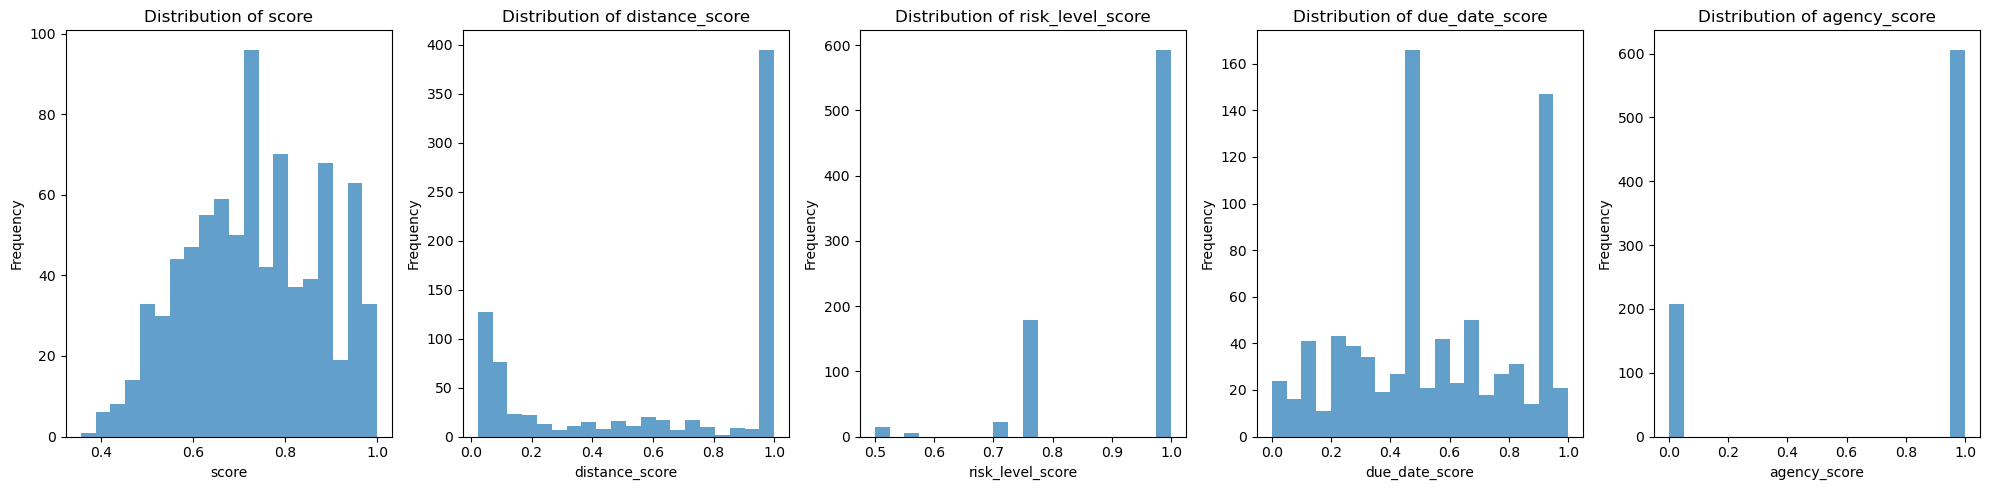

Average distance for On-Site inspections: 67.03933296524063


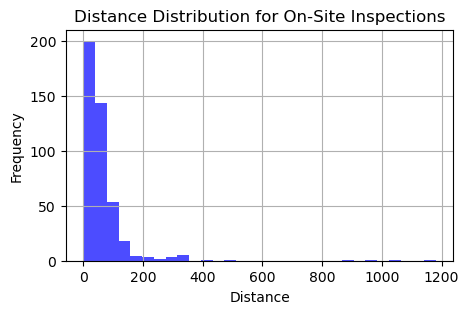

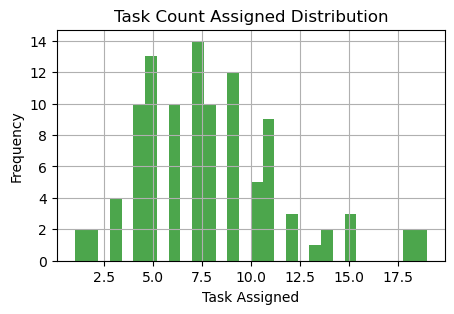

Reps with no tasks assigned: 0
Tasks not assigned: 0


In [14]:
engine.get_result_summary()

Average score: 0.713564859963394
Average distance_score: 0.733807872185561 Weight: 2
Average risk_level_score: 0.8621805896805897 Weight: 3
Average due_date_score: 0.5524160524160524 Weight: 4
Average agency_score: 0.7653562653562653 Weight: 1


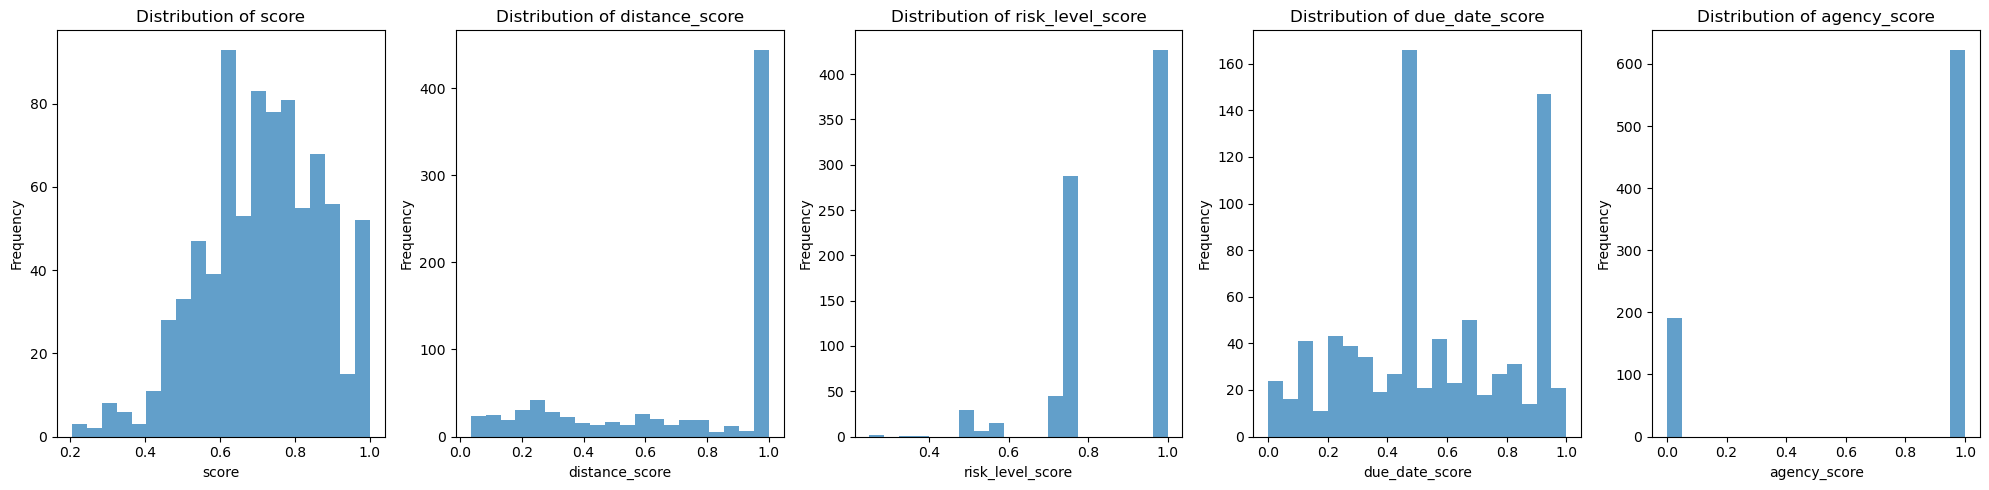

Average distance for On-Site inspections: 67.99899547385994


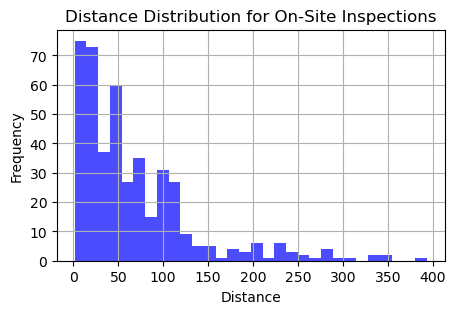

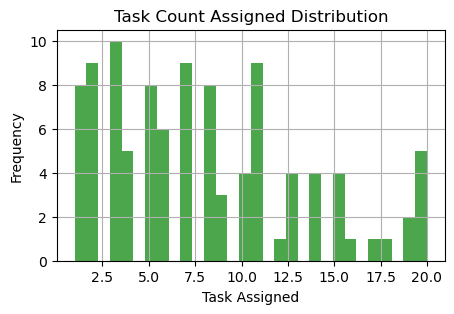

Reps with no tasks assigned: 4
Tasks not assigned: 0


In [13]:
engine.get_result_summary()

In [17]:
engine.rep_assignment_summary

rep_name  key_account  task_count  \
0          Addante, Debra         True           2   
1         Akeseh, Barbara        False           0   
2           Alger, Rachel         True           0   
3             Anton, Ryan         True           1   
4     Aschettino, Vincent        False           0   
5              Ben, Kevin        False           0   
6            Benton, Dave        False           1   
7             Boyer, Gary        False           0   
8           Bradley, John        False           0   
9      Bramblett, Phillip        False           0   
10       Brennan, Kiernan        False           0   
11         Brinton, Floyd         True           1   
12             Brown, Lee        False           0   
13            Brown, Matt        False           1   
14          Bunney, Kayla        False           2   
15           Bunney, Zach         True           0   
16       Callisto, Joseph        False           0   
17          Casar, Daniel        False           1   
18        Clevenger, Anna        False           8   
19        Courtney, Scott         True           2   
20         Crum, Danielle         True           4   
21         Czerkis, Chris        False           3   
22           Dahms, Chris        False           2   
23          Damrow, Kalli         True           1   
24          DeRemer, Adam        False           0   
25     DeSormeau, Jeffrey        False           2   
26            Dick, Kathy        False           0   
27        Distefano, John         True           1   
28         Ericson, Rylie        False           0   
29       Erisman, Patrick         True           4   
30        Eubanks, Robert         True           4   
31     Farrar-Brown, Jill         True           5   
32         Forrest, Craig        False           0   
33         Forrest, Jerry        False           2   
34        Gordon, Michael        False           2   
35           Griinke, Dan         True           2   
36           Grimm, Kevin        False           2   
37         Guajardo, Noel         True           0   
38          Gwidt, Ashley         True           0   
39             Hall, Anna         True           0   
40          Hanley, Marty        False           1   
41          Hansen, Haley        False           5   
42     Hartsuck, Christal        False           0   
43         Helton, Kristy         True           1   
44          Herndon, Mike         True           1   
45         Holstege, Nate         True           7   
46              Ims, Cory         True           4   
47    Johnson, CJ (Cyril)        False           4   
48           Jones, David        False           0   
49     Jurgelonis, Joseph         True           1   
50          Kaufman, Jake        False           0   
51        Kristof, Robert        False           1   
52          Kult, Chelsea        False           2   
53        Langner, Daniel         True           8   
54            Lario, Mark        False           2   
55         Lowry, Brennan         True           5   
56       Maddens, Tiffany         True           0   
57       Maggiaro, Ronald        False           0   
58         Magyar, Laszlo         True           0   
59        Malarney, Brian        False           8   
60       Marks, Elizabeth        False           0   
61       McCarthy, Connor        False           3   
62     McClinton, Bernard        False           0   
63         McCord, Jeremy         True           1   
64    McDermott, Michelle         True           0   
65       Moorman, Clayton         True           0   
66           Ogg, Rebecca        False           0   
67          Ousley, Eddie         True           1   
68        Overton, Philip        False           0   
69      Phillips, Douglas         True           0   
70            Ploetz, Ben         True           2   
71              Post, Joe         True           1   
72            Price, Tony        False           0   
73      Prontaut, Mat